In [ ]:
# Recurrent Neural Network
## David Darigan (C00263218)

# Change 1

Initial run has training at 10% loss on training and 96% accuracy on testing
<br>
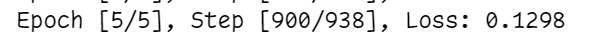
<br>
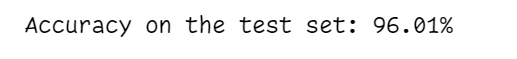

# Change 2

Changed pass count to 10, ended up with the exact same loss rate.
<br>
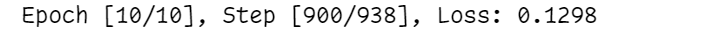
<br>
And 95% accuracy on the test set
<br>
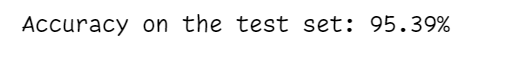

# Change 3

Changed layers from 2 to 4, loss rate reduced by 2%
<br>
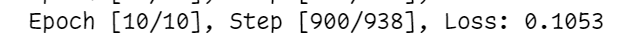
<br>
This is reflected in the testing accuracy which increased by 2%~
<br>
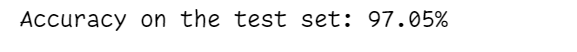

# Change 4
Increased layers up to 10 which overall reduced effectiveness
<br>

<br>
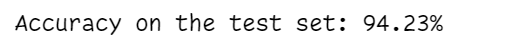


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Loading training / test sets
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
# Define RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        # Use only the output from the last time step
        out = self.fc(out[:, -1, :]) 
        return out

In [20]:
# Hyperparameters

# Pixels per row
input_size = 28 

# Rows in image
sequence_length = 28  

hidden_size = 128
num_layers = 4
num_classes = 10
batch_size = 64
num_epochs = 10
learning_rate = 0.001

In [21]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = RNN(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Saving the model
torch.save(model.state_dict(), 'rnn_model.pth')

Epoch [1/10], Step [100/938], Loss: 1.0574
Epoch [1/10], Step [200/938], Loss: 0.7711
Epoch [1/10], Step [300/938], Loss: 0.2723
Epoch [1/10], Step [400/938], Loss: 0.4079
Epoch [1/10], Step [500/938], Loss: 0.3079
Epoch [1/10], Step [600/938], Loss: 0.3772
Epoch [1/10], Step [700/938], Loss: 0.2395
Epoch [1/10], Step [800/938], Loss: 0.3204
Epoch [1/10], Step [900/938], Loss: 0.1860
Epoch [2/10], Step [100/938], Loss: 0.2300
Epoch [2/10], Step [200/938], Loss: 0.2379
Epoch [2/10], Step [300/938], Loss: 0.3143
Epoch [2/10], Step [400/938], Loss: 0.1917
Epoch [2/10], Step [500/938], Loss: 0.1873
Epoch [2/10], Step [600/938], Loss: 0.3168
Epoch [2/10], Step [700/938], Loss: 0.2174
Epoch [2/10], Step [800/938], Loss: 0.4739
Epoch [2/10], Step [900/938], Loss: 0.1776
Epoch [3/10], Step [100/938], Loss: 0.1133
Epoch [3/10], Step [200/938], Loss: 0.0720
Epoch [3/10], Step [300/938], Loss: 0.1587
Epoch [3/10], Step [400/938], Loss: 0.2213
Epoch [3/10], Step [500/938], Loss: 0.0880
Epoch [3/10

In [23]:
# Testing the model

saved_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Load the saved model
saved_model.load_state_dict(torch.load('rnn_model.pth'))
saved_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total}%')